(junction-example)=
# Junctions and junction gates

This example illustrates how simple tunnel junctions can be modelled with the [](tunnel) object, and can be an illustrative guide for how to replace the old [](junction) and [](junction_gate) objects in existing SHOP datasets.

The model setup for this example is available in the following format:
- pyshop
    - [](junction_model.py)

In [1]:
#Necessary imports used in all examples
import pandas as pd
import plotly.graph_objects as go
from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it
from junction_model import build_model, run_model

## Run a simple junction model

First we build a new model with one [](plant) below two [reservoirs](reservoir) connected with three [tunnels](tunnel). Note that the main tunnel of the plant is explicitly modelled as a tunnel object, and the [main_loss](plant:main_loss) of the plant is therefore set to zero.

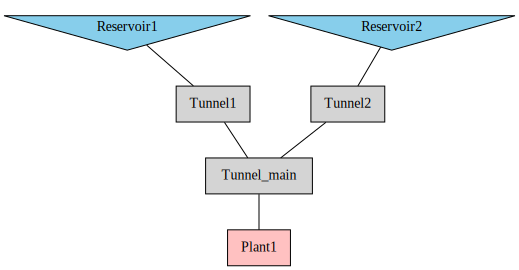

In [2]:
shop = ShopSession()
build_model(shop)
shop.model.build_connection_tree()

The basic junction model is optimized and the objective function is saved for later comparison.

In [3]:
run_model(shop)
objective_junction = -shop.model.objective.average_objective.grand_total.get()

The plots below show the [reservoir level](reservoir:head) of both reservoirs and the [tunnel flow](tunnel:flow) in all three tunnels. There is only equalizing flow between the two reservoirs in the beginning with no flow through the power station. Then the power station is turned on by the end of the optimization period and draws water from both reservoirs. Reservoir2 is completely drained by the end of the optimization horizon, while Reservoir1 still has water left. The market price is high compared to the water value of the reservoirs, so this behaviour is expected.

In [4]:
fig = go.Figure()
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    level = rsv.head.get()
    lrl = rsv.lrl.get()
    fig.add_trace(go.Scatter(x=level.index, y=level.values, name=name))
    fig.add_trace(go.Scatter(x=level.index, y=[lrl]*len(level),name=name+" lrl", line={"dash":"dash"}))
    
fig.update_layout(title="Reservoir level")
fig.show()

fig = go.Figure()
for t in shop.model.tunnel:
    name = t.get_name()
    flow = t.flow.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values, name=name))
fig.update_layout(title="Tunnel flow")
fig.show()

## Optimizing a binary gate in the junction

The same model is built again, but now a binary gate is added to Tunnel2. The [gate_opening_curve](tunnel:gate_opening_curve) and [initial_opening](tunnel:initial_opening) are the only required input for defining a binary gate. If the gate can be operated in a continuous fashion, the [continuous_gate](tunnel:continuous_gate) identifier can be set on the tunnel. Note that optimizing the gate position of binary gates can be a computationally heavy task, even for relatively simple systems. Continuous gates do not come with the same computational complexity, but the solution could be prone to flipping between similar states from one SHOP iteration to the next. Adding a [gate_adjustment_cost](tunnel:gate_adjustment_cost) will penalize the change of gate position from one time step to the next, and could help reduce calculation time for binary gates and the flipping of solutions for continuous gates, though its effectiveness is case-dependent. Another trick could be to set the CPLEX parameter "MIP Emphasis switch" (id 2058) to focus on creating a tighter best bound of the MIP solution (value 3). This is sometimes beneficial in gate optimization problems, and can be set with the generic [cplex_int_params](global_settings:cplex_int_params) attribute on the [](global_settings) object.

The old [](junction_gate) object did not allow for optimizing the gate position but relied on gate schedules as input to decide which tunnel arms were open and closed. This can also be done for tunnels with gates by setting the [gate_opening_schedule](tunnel:gate_opening_schedule) attribute, which will avoid the computational problems that comes with optimizing the gate position.

In [5]:
shop = ShopSession()
build_model(shop)

t2 = shop.model.tunnel["Tunnel2"]
t2.gate_opening_curve.set(pd.Series([0,1], index=[0,1]))
t2.initial_opening.set(1)

#Set mip emphasis to focus on tightening the best bound of the solution
gs = shop.model.global_settings.global_settings
gs.cplex_int_params.set(pd.Series([3],index=[2058]))

run_model(shop)
objective_junc_gate = -shop.model.objective.average_objective.grand_total.get()

print(f"Improved net income when optimizing junction gate: {objective_junc_gate - objective_junction:.2f}€")

Improved net income when optimizing junction gate: -44933.15€


Allowing the gate on the tunnel between Reservoir2 and the junction to be opened and closed improved the objective function, as expected. The plant can now increase the amount of power produced by running for several additional hours in the beginning of the optimization. When Reservoir2 is completely drained, the gate is closed so that the plant can continue to drain Reservoir1. Both reservoirs are completely drained by the end of the optimization, unlike the first run without any gate control.

In [6]:
fig = go.Figure()
for rsv in shop.model.reservoir:
    name = rsv.get_name()
    level = rsv.head.get()
    lrl = rsv.lrl.get()
    fig.add_trace(go.Scatter(x=level.index, y=level.values, name=name))
    fig.add_trace(go.Scatter(x=level.index, y=[lrl]*len(level),name=name+" lrl", line={"dash":"dash"}))

fig.update_layout(title="Reservoir level")
fig.show()

fig = go.Figure()
for t in shop.model.tunnel:
    name = t.get_name()
    flow = t.flow.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values, name=name))
fig.update_layout(title="Tunnel flow")
fig.show()

fig = go.Figure()
for t in shop.model.tunnel:
    name = t.get_name()
    flow = t.gate_opening.get()
    fig.add_trace(go.Scatter(x=flow.index, y=flow.values, name=name))
fig.update_layout(title="Tunnel gate opening")
fig.show()